# Notebook for Gene Set Enrichment Analysis for Visium Glioblastoma (run1_1) dataset

Last updated: 08/03/2022


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt

import gseapy

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

Creating directory /home/yangjoon.kim/.config/bioservices 


In [2]:
# plotting parameters
# set the parameters for figure
sc.set_figure_params(scanpy=True, dpi=300, dpi_save=250,
                     frameon=False,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x', figsize=(5,5))
#plt.rcParams['figure.figsize'] = (6,6)

## Load the Visium glioblastoma anndata object - (run1_1) 

- This has manual annotation of tumor vs healthy.
- saves raw counts in the layer["counts"]
- has pre-computed UMAP, leiden clustering, etc.
- saves t-test, wilcoxon tests on healthy vs tumor (healthy as the control)



In [4]:
adata = sc.read_h5ad("/mnt/ibm_lg/spatial-seq/visium_pilot/data/annotated_data/CMS75-GBMA7_brain_visium_Run1_1_visium_filtered_annotated_umap.h5ad")

In [13]:
adata

AnnData object with n_obs × n_vars = 2158 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'condition', 'coarse', 'fine', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'condition_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 't-test', 'umap', 'wilcoxon'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Gene Set Enrichment Analysis (GSEA)

We'd like to see if the list DE genes belong to any known pathways of interest, that could guide us to assess how different glioblastoma is from the healthy cells.

There are several choices of gene set enrichment analysis
- GSEApy (python-ported GSEA)
- pathfindR (R package to find enriched pathways, used for CTA paper)




In [7]:
# filter the list of genes for tumor and healthy cells, respectively, for the input of gseapy
list_DE_genes_tumor = []
for i in range(0,len(adata.uns["wilcoxon"]["names"])):
    gene = adata.uns["wilcoxon"]["names"][i][0]
    if gene.startswith('mt-'):
        list_DE_genes_tumor = list_DE_genes_tumor
    else:
        list_DE_genes_tumor.append(gene)
    
list_DE_genes_tumor

['Aldoc',
 'Mbp',
 'Scd2',
 'Ndrg2',
 'Mobp',
 'Sparcl1',
 'Fth1',
 'Mt3',
 'Mt1',
 'Glul',
 'Cst3',
 'Snap25',
 'Aplp1',
 'Slc1a2',
 'Atp1a2',
 'Stmn3',
 'Pink1',
 'Ldhb',
 'Atp1b1',
 'Ptgds',
 'Sparc',
 'Ttyh1',
 'Nap1l5',
 'Snrpn',
 'Chchd10',
 'Sez6l2',
 'Plp1',
 'Pcsk1n',
 'Eef1a2',
 'Dynll2',
 'Eno2',
 'Atp1b2',
 'Ckb',
 'Tubb4a',
 'Kif1a',
 'Kif5a',
 'Rtn1',
 'Vsnl1',
 'S100b',
 'Ndrg4',
 'Gpm6b',
 'Rab3a',
 'Cox4i1',
 'Cplx1',
 'Stmn2',
 'Calm1',
 'Cpe',
 'Aldoa',
 'Agt',
 'Nefl',
 'Selenow',
 'Plekhb1',
 'Pcp4',
 'Pea15a',
 'Dnm1',
 'Tuba4a',
 'Enho',
 'Hcn2',
 'Atp1a3',
 'Map1a',
 'Thy1',
 'Car2',
 'Mdh1',
 'Abat',
 'Slc22a17',
 'Camk2n1',
 'Mal',
 'Meg3',
 'Apod',
 'Ttc3',
 'Ntrk2',
 'Sncb',
 '2900097C17Rik',
 'Dbndd2',
 'Gpm6a',
 'Stxbp1',
 'Slc6a1',
 'Faim2',
 'Calm3',
 'Dpysl2',
 'Sv2a',
 'Htra1',
 'Vamp1',
 'Qdpr',
 'Prnp',
 'Scn1b',
 'Kcnj10',
 'Nsg1',
 'Ncdn',
 'Syp',
 'Apbb1',
 'Pvalb',
 'Rcan2',
 'Rab6b',
 'Acsbg1',
 'Csrp1',
 'Tagln3',
 'Gng13',
 'Vamp2',
 'Abca2',


In [8]:
adata.uns["wilcoxon"]

{'logfoldchanges': array([( 4.9003406,  4.736986 ), ( 4.8288555,  2.673837 ),
        ( 2.6457307,  1.8504986), ..., (-1.8504986, -2.6457307),
        (-2.673837 , -4.8288555), (-4.736986 , -4.9003406)],
       dtype=[('healthy', '<f4'), ('tumor', '<f4')]),
 'names': array([('Aldoc', 'AI506816'), ('Mbp', 'Rps12'), ('mt-Nd2', 'Rpl41'), ...,
        ('Rpl41', 'mt-Nd2'), ('Rps12', 'Mbp'), ('AI506816', 'Aldoc')],
       dtype=[('healthy', 'O'), ('tumor', 'O')]),
 'params': {'corr_method': 'benjamini-hochberg',
  'groupby': 'condition',
  'method': 'wilcoxon',
  'reference': 'rest',
  'use_raw': False},
 'pvals': array([(1.19705373e-293, 0.00000000e+000),
        (1.06561039e-287, 0.00000000e+000),
        (3.44357522e-282, 0.00000000e+000), ...,
        (0.00000000e+000, 3.44357522e-282),
        (0.00000000e+000, 1.06561039e-287),
        (0.00000000e+000, 1.19705373e-293)],
       dtype=[('healthy', '<f8'), ('tumor', '<f8')]),
 'pvals_adj': array([(1.68029911e-290, 0.00000000e+000),
    

In [ ]:
list_DE_genes_tumor

In [18]:
#?gseapy.enrichr
glist = sc.get.rank_genes_groups_df(adata, group='healthy', 
                                    key='wilcoxon', log2fc_min=0.25, 
                                    pval_cutoff=0.01)['names'].squeeze().str.strip().tolist()
print(len(glist))

1440


In [20]:
#?gseapy.enrichr
glist_tumor = sc.get.rank_genes_groups_df(adata, group='tumor', 
                                    key='wilcoxon', log2fc_min=0.25, 
                                    pval_cutoff=0.01)['names'].squeeze().str.strip().tolist()
print(len(glist_tumor))

6260


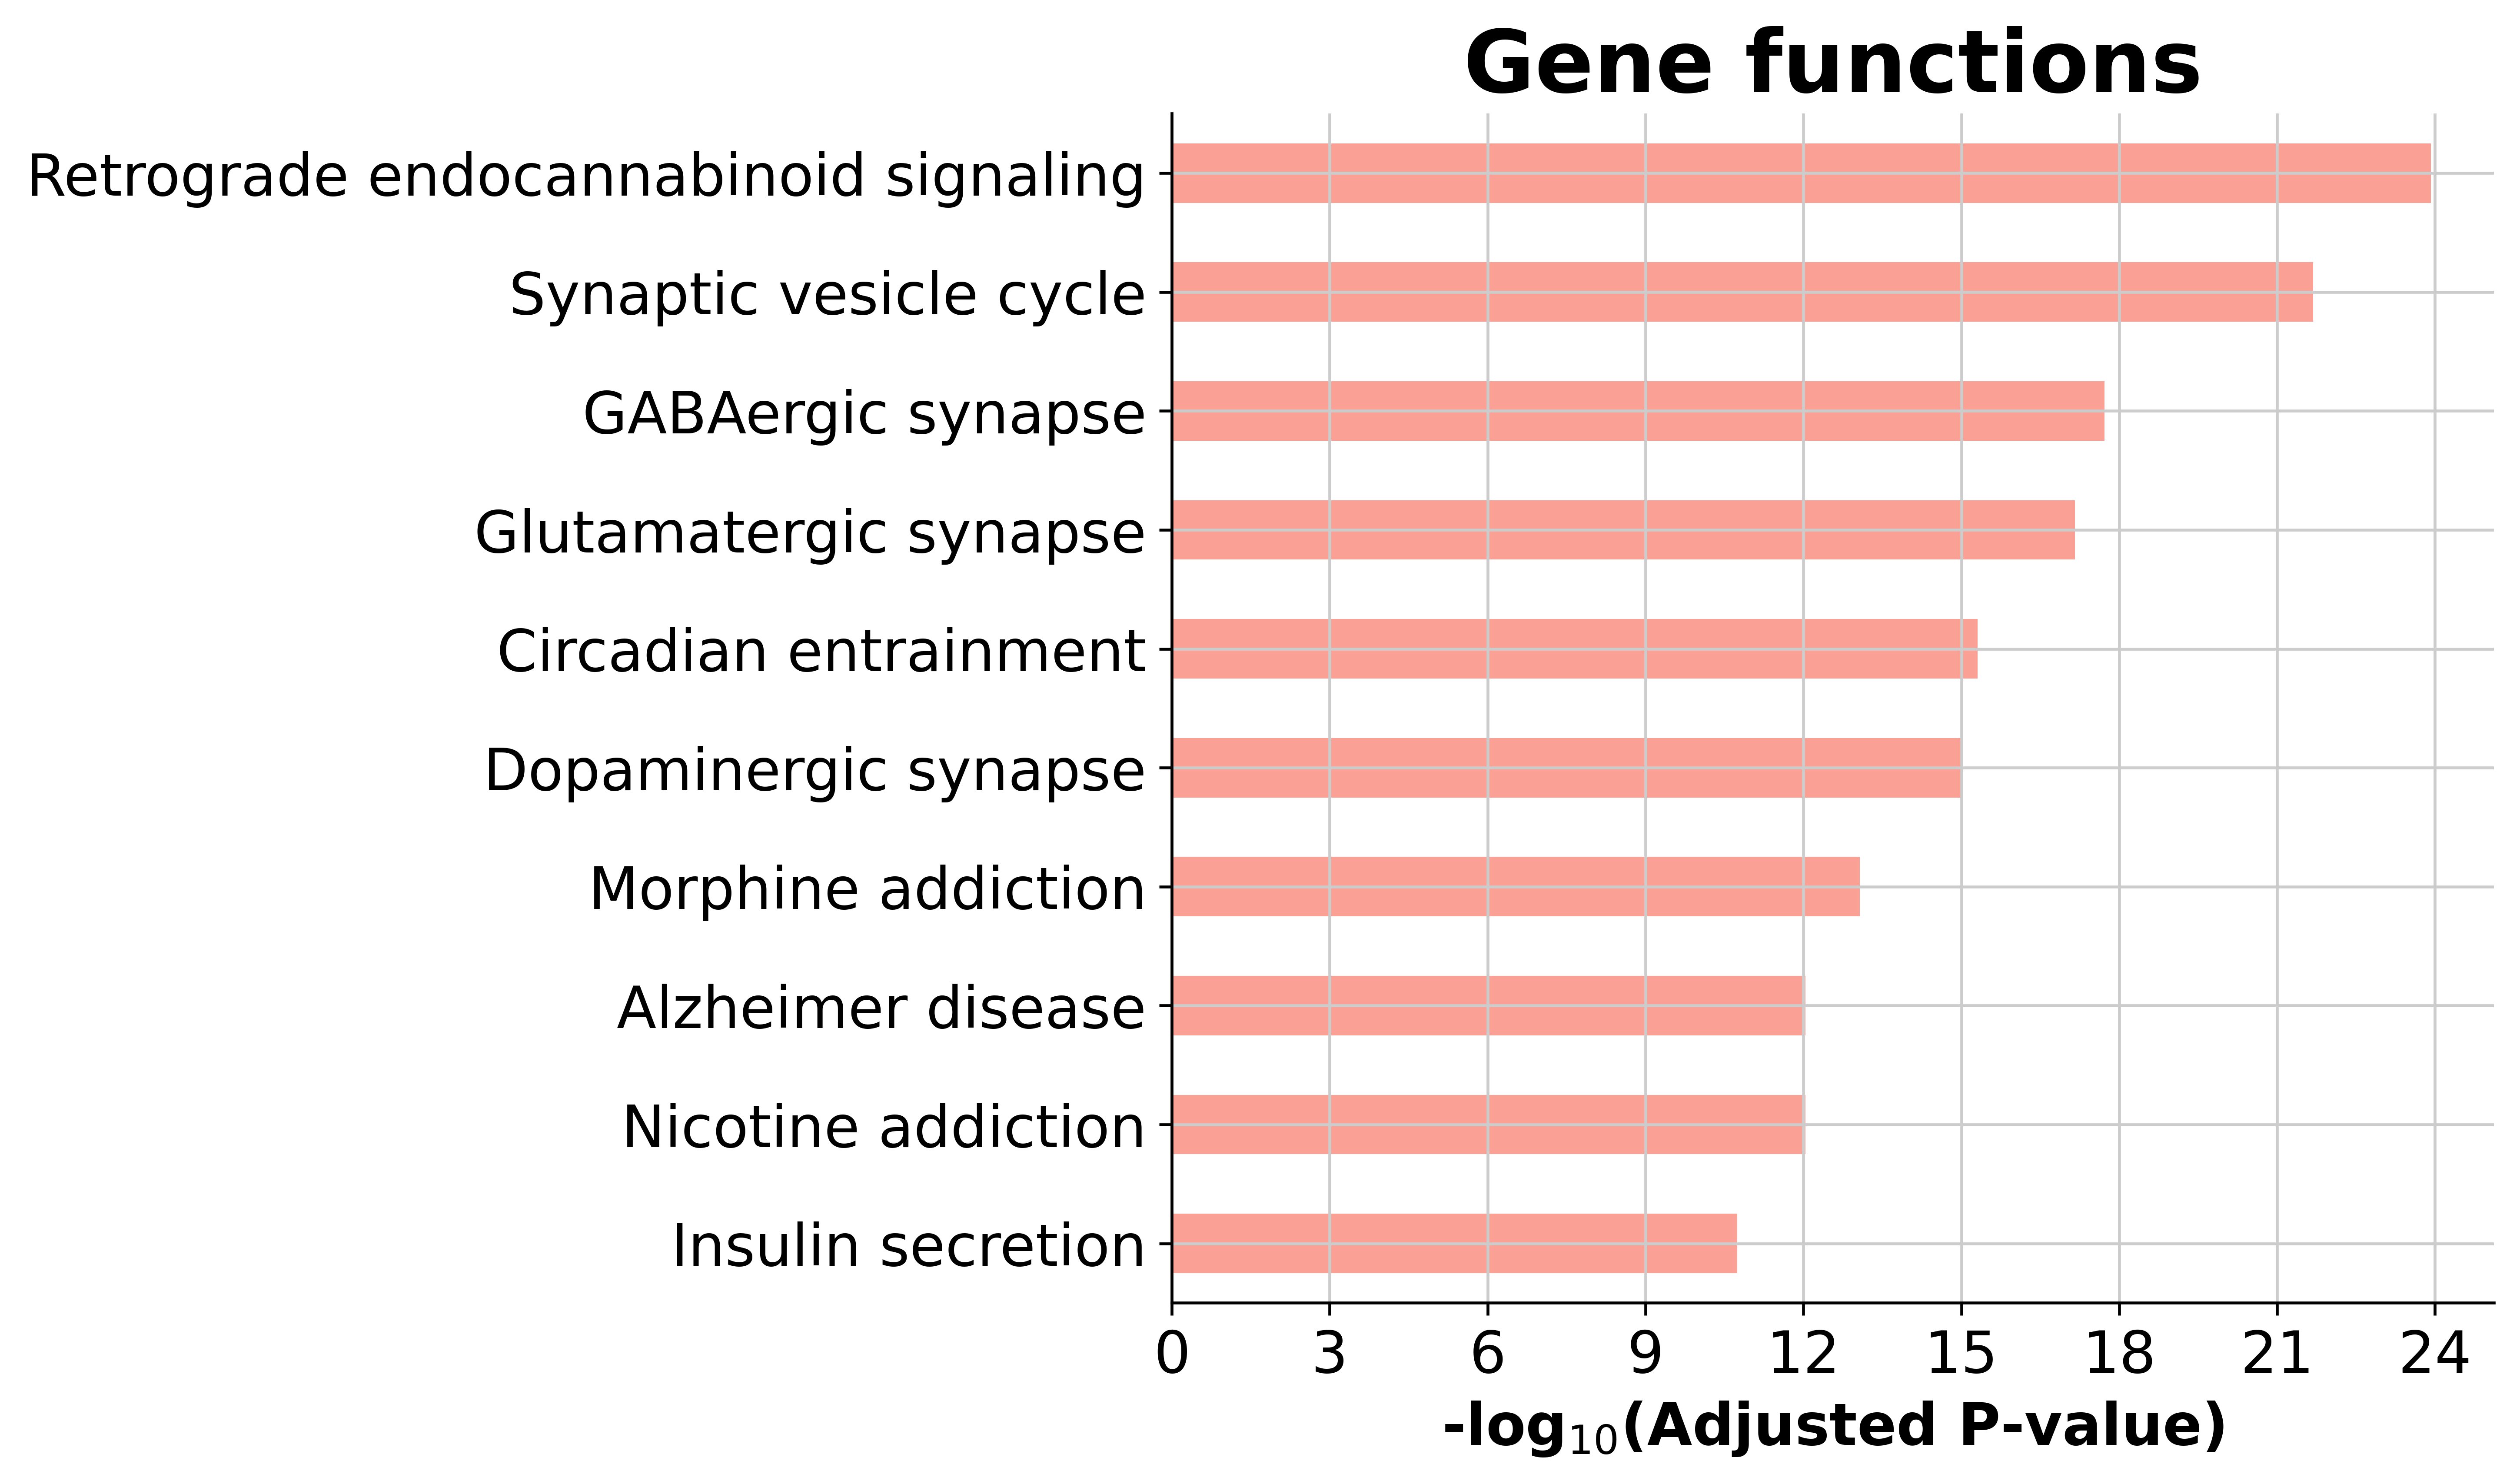

In [19]:
enr_res = gseapy.enrichr(gene_list= glist,
                     organism='Mouse',
                     gene_sets='KEGG_2019_Mouse',
                     description='pathway',
                     cutoff = 0.5)
gseapy.barplot(enr_res.res2d,title='Gene functions')

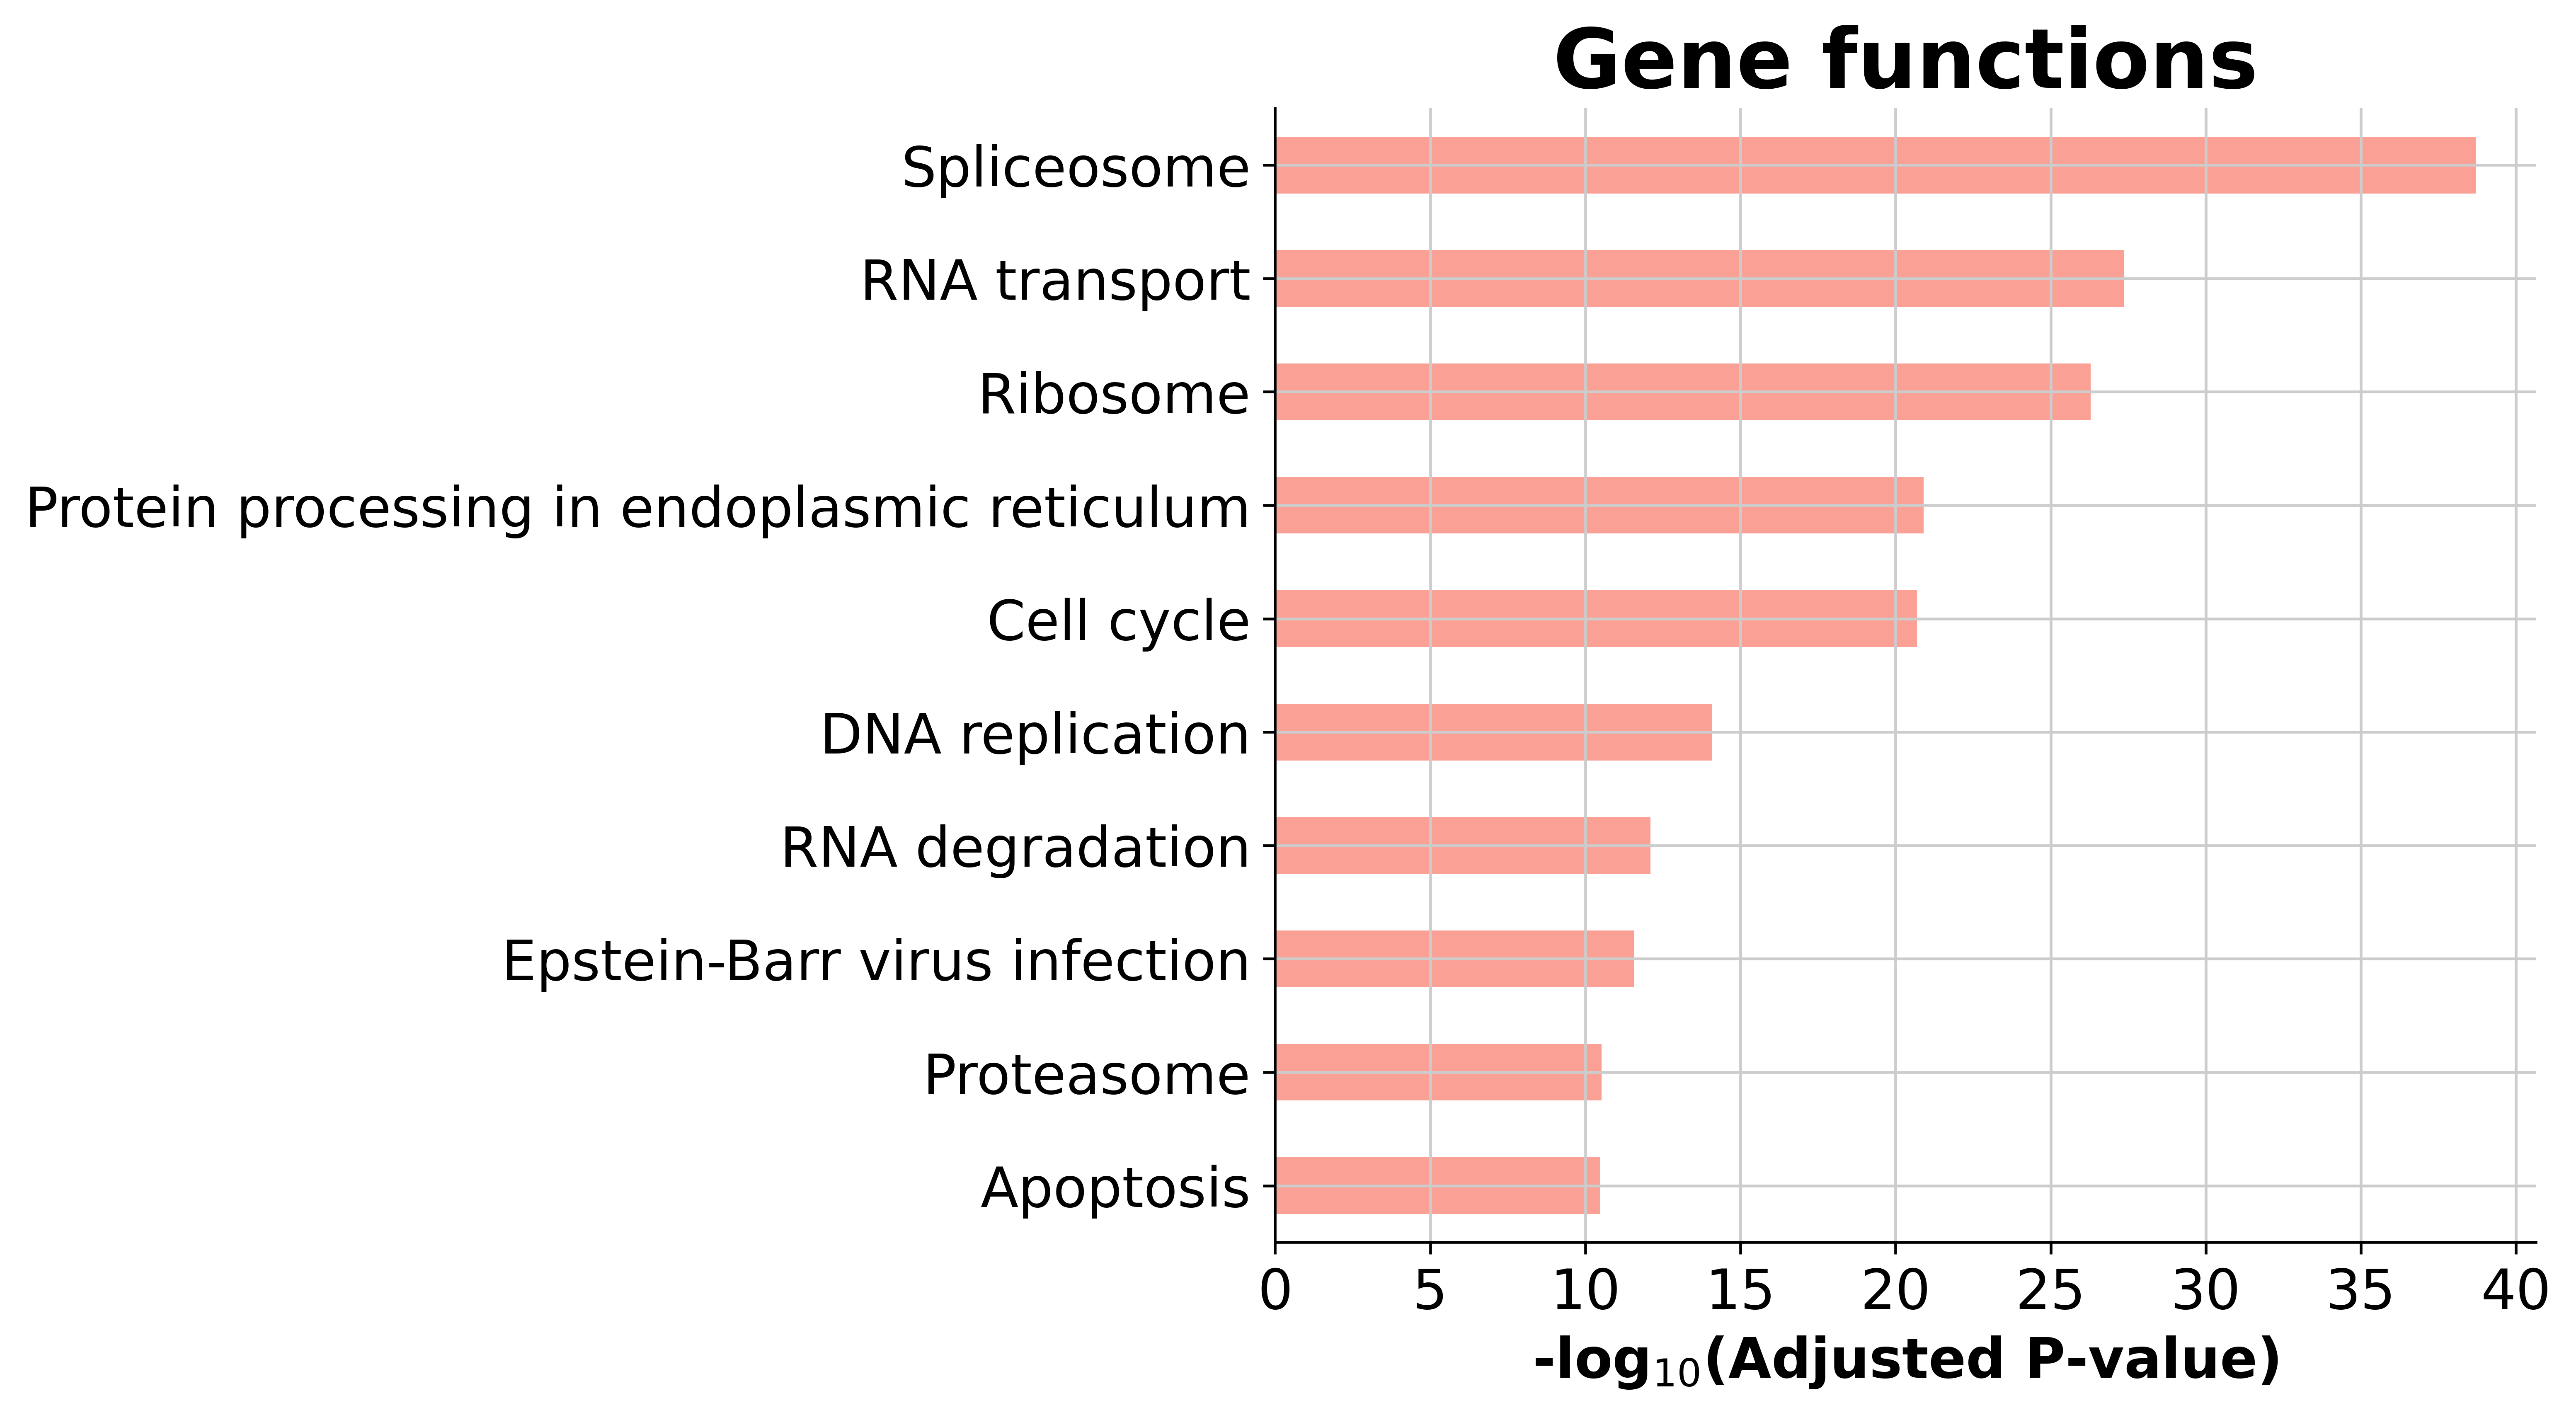

In [22]:
enr_res_tumor = gseapy.enrichr(gene_list= glist_tumor,
                     organism='Mouse',
                     gene_sets='KEGG_2019_Mouse',
                     description='pathway',
                     cutoff = 0.5)
gseapy.barplot(enr_res_tumor.res2d,title='Gene functions')